**Exploratory Data Analysis of the Data (EDA)**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#PARAMS
local_image_size_x = 30
local_image_size_y = 30
TIMESTEP_OUR = 4
Prediction_TIMESTEP = 1
BATCHSIZE = 1129
LOSS = 'mse'
OPTIMIZER = 'adam'
EPOCH = 3
LEARN = 0.0005 #5e-06
WEIGHT_DECAY = 5e-5
TRAIN_RATIO = 0.8
previous_time_input = TIMESTEP_OUR
prediction_of_time = Prediction_TIMESTEP

In [3]:
base_directory = os.getcwd()
data_path = os.path.join(base_directory)

region_path = os.path.join(data_path, 'flowioK_TaxiNYC_20160101_20160228_60min.npy')
temporal_path = os.path.join(data_path, 'Temporal_Master_Grid_NYC30x30(60_min_resolution).npy')

region = np.load(region_path)
temporal = np.load(temporal_path)

In [4]:
print("Region Shape:", region.shape)
print("Temporal Shape:", temporal.shape)
print("Region Data Types:", region.dtype)
print("Temporal Data Types:", temporal.dtype)

Region Shape: (1416, 30, 30, 1)
Temporal Shape: (1416, 38, 30, 30)
Region Data Types: float64
Temporal Data Types: float64


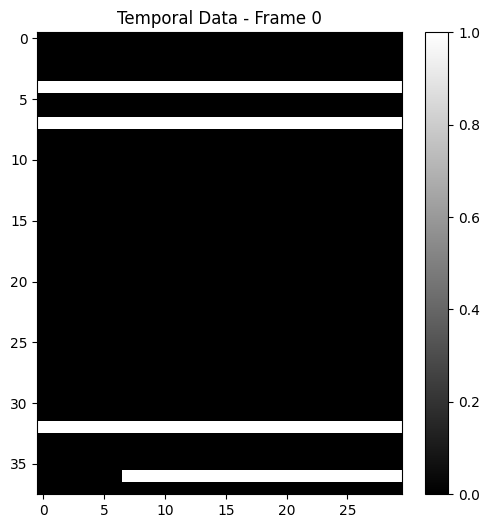

In [5]:
# Temporal

frame_index = 0
# Plot a single frame
plt.figure(figsize=(6, 6))
plt.imshow(temporal[frame_index, :, :, 0], cmap='gray')
plt.colorbar()
plt.title(f"Temporal Data - Frame {frame_index}")
plt.show()

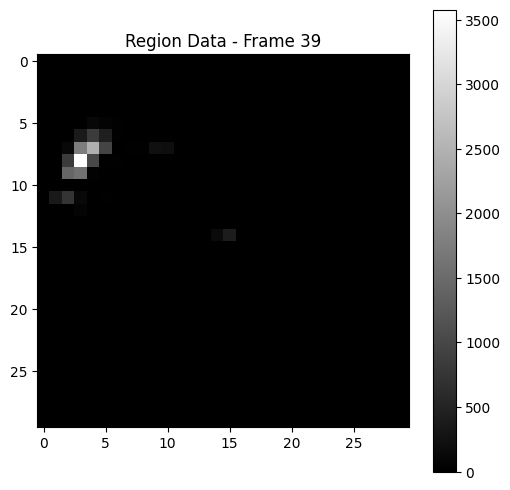

In [6]:
# Region

frame_index = 39
# Plot a single frame
plt.figure(figsize=(6, 6))
plt.imshow(region[frame_index, :, :, 0], cmap='gray')
plt.colorbar()
plt.title(f"Region Data - Frame {frame_index}")
plt.show()

In [7]:
temporal = np.array(temporal)
region = np.transpose(region, (0, 3, 1, 2))
print("TEMPORAL FILE SHAPE:", temporal.shape)
print("SPATIAL/REGION FILE SHAPE:", region.shape)

TEMPORAL FILE SHAPE: (1416, 38, 30, 30)
SPATIAL/REGION FILE SHAPE: (1416, 1, 30, 30)


SPATIAL/REGION SHAPE: (1416, 900)


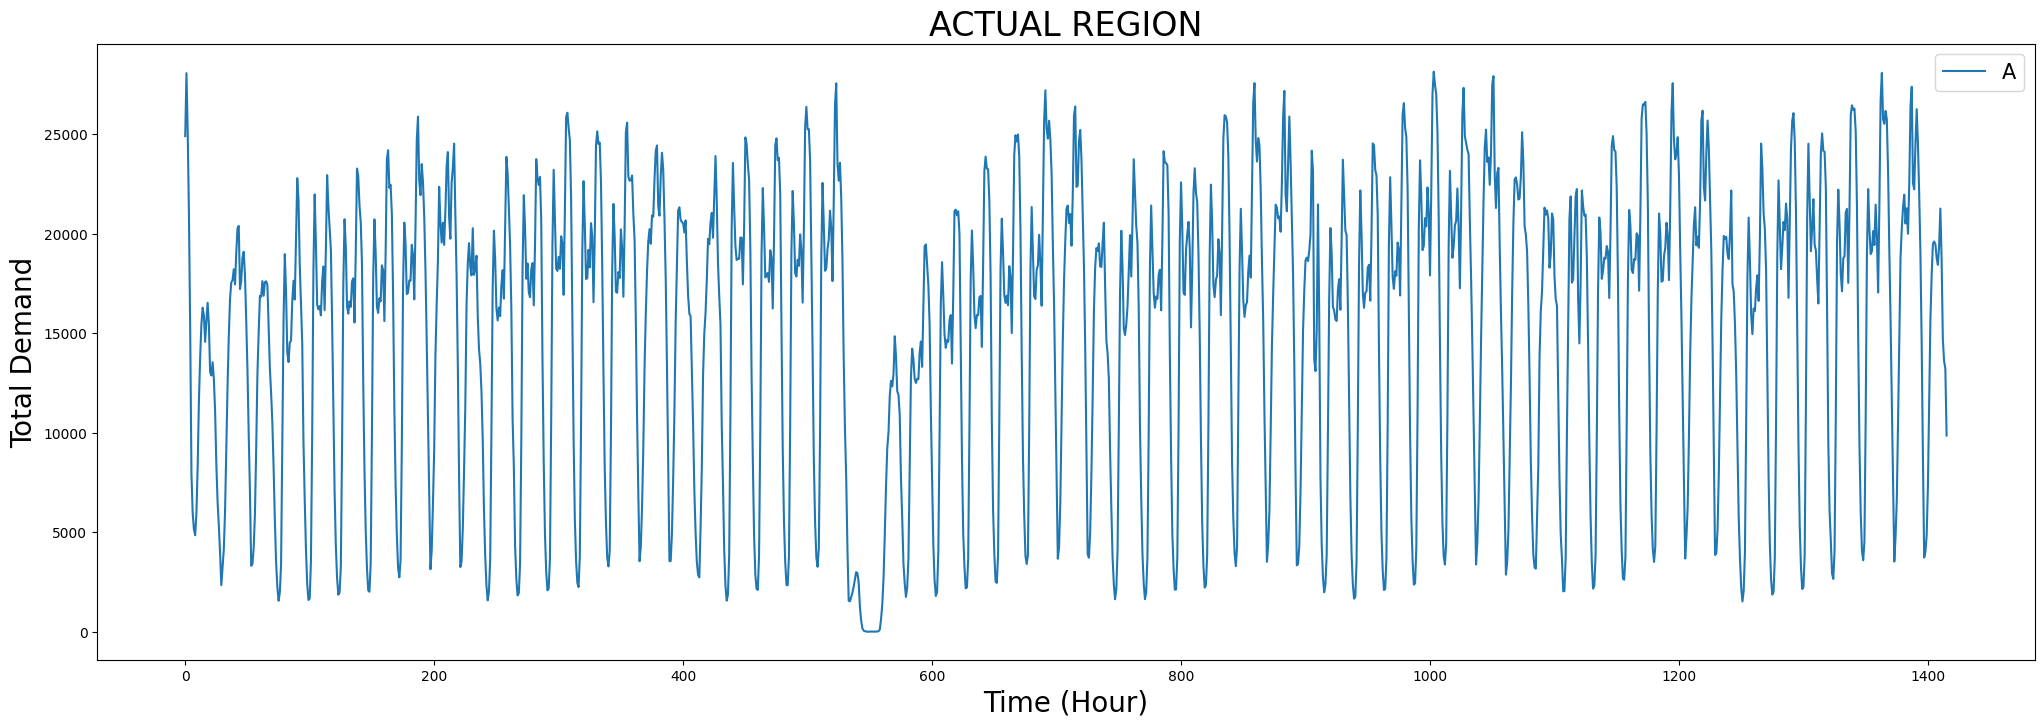

In [8]:
reshaped_reg = np.sum(region, axis=1).reshape(region.shape[0], local_image_size_x * local_image_size_y)
print("SPATIAL/REGION SHAPE:", reshaped_reg.shape)

plt.figure(figsize=(25, 8))
plt.title('ACTUAL REGION', fontsize=24)
plt.plot(np.sum(reshaped_reg, axis=1))
# plt.plot(np.sum(reshaped_pred, axis=1))
# plt.legend(['Actual', 'Predicted'], fontsize=15)
plt.legend('Actual', fontsize=15)
plt.ylabel('Total Demand', fontsize=20)
plt.xlabel('Time (Hour)', fontsize=20)
plt.show()

TEMPORAL SHAPE: (1416, 900)


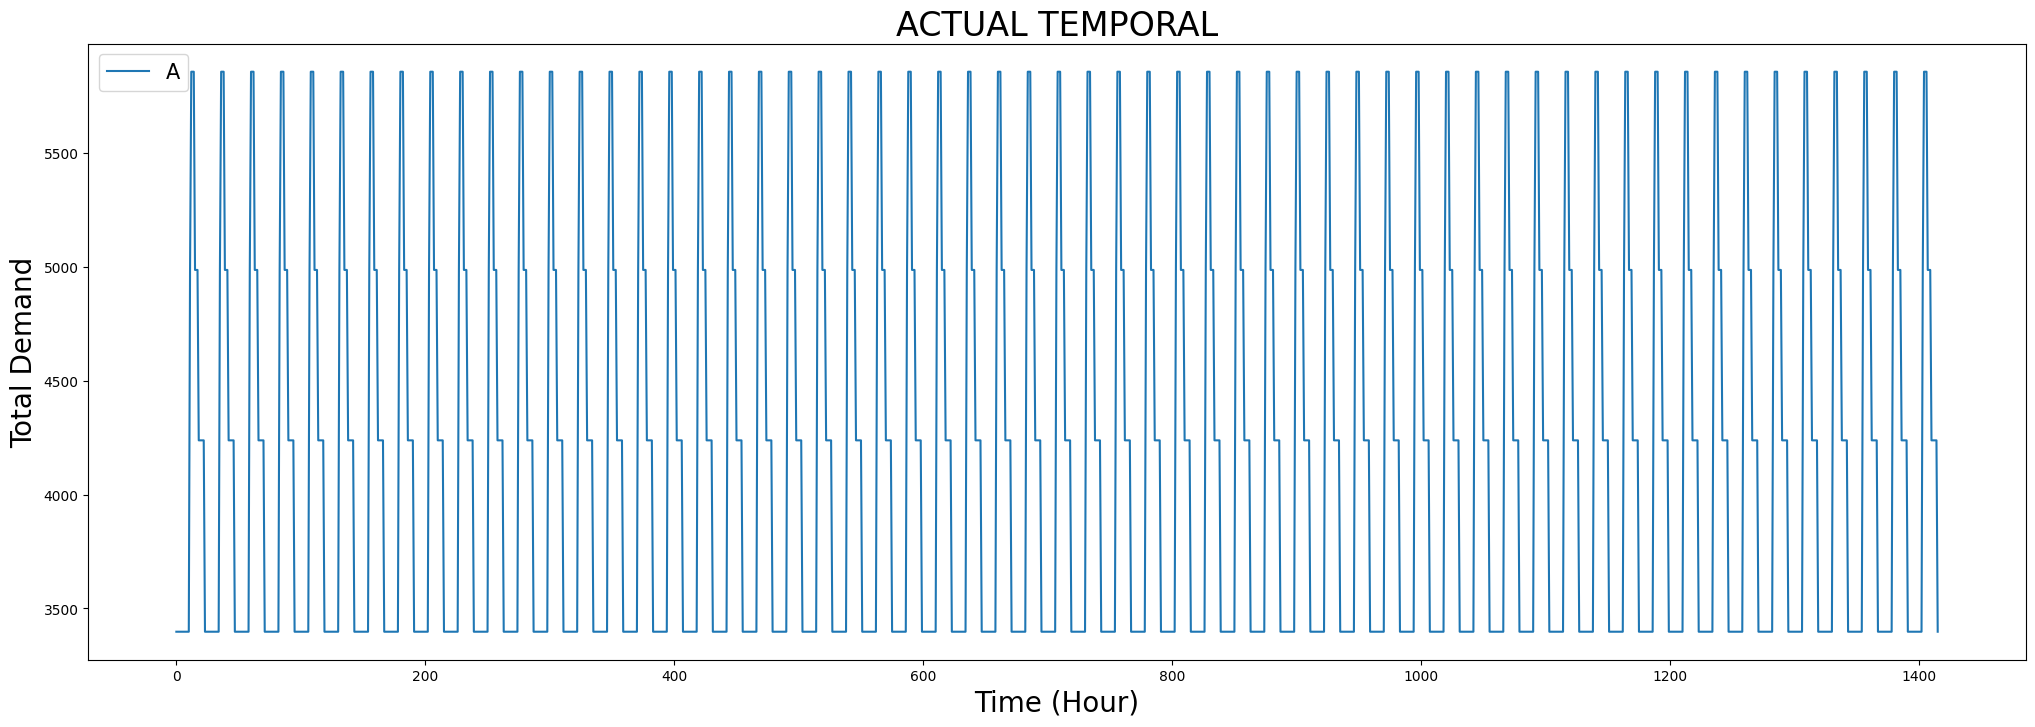

In [9]:
reshaped_temp = np.sum(temporal, axis=1).reshape(temporal.shape[0], local_image_size_x * local_image_size_y)
print("TEMPORAL SHAPE:", reshaped_temp.shape)

plt.figure(figsize=(25, 8))
plt.title('ACTUAL TEMPORAL', fontsize=24)
plt.plot(np.sum(reshaped_temp, axis=1))
# plt.plot(np.sum(reshaped_pred, axis=1))
# plt.legend(['Actual', 'Predicted'], fontsize=15)
plt.legend('Actual', fontsize=15)
plt.ylabel('Total Demand', fontsize=20)
plt.xlabel('Time (Hour)', fontsize=20)
plt.show()

In [10]:
def data_slider(data, type_of_data, previous_time_input=TIMESTEP_OUR, prediction_of_time=Prediction_TIMESTEP):
    data = np.array(data)
    data_array = []
    for i in range(np.shape(data)[0] - (previous_time_input + prediction_of_time) + 1):
        temp = data[i:i + previous_time_input]
        data_array.append(temp)
    data_array = np.array(data_array)
    return data_array

In [11]:
region_data = data_slider(region, "Spatial")
region_data = region_data.reshape((region_data.shape[0], previous_time_input, local_image_size_x, local_image_size_y))

y_true = []
for i in range(np.shape(region)[0] - (previous_time_input + prediction_of_time) + 1):
    temp = region[i + previous_time_input:i + (previous_time_input + prediction_of_time)]
    y_true.append(temp)
y_true = np.array(y_true)

y_true = y_true.reshape((y_true.shape[0], prediction_of_time*local_image_size_x*local_image_size_y))

trainx_1, valx_1, ytrain, val_y = train_test_split(region_data, y_true,
                                                    train_size=TRAIN_RATIO, random_state=42, shuffle=True)

print("-"*100)
print("Training Data: ")
print("Regional data training shape:", trainx_1.shape)
# print("Temporal data training shape:", trainx_2.shape)
print("True values Training shape:  ", ytrain.shape)
print("-"*100)

print("Val Data: ")
print("Regional data Validation shape:", valx_1.shape)
# print("Temporal data Validation shape:", valx_2.shape)
print("True values Validation shape:  ", val_y.shape)
print("-"*100)

----------------------------------------------------------------------------------------------------
Training Data: 
Regional data training shape: (1129, 4, 30, 30)
True values Training shape:   (1129, 900)
----------------------------------------------------------------------------------------------------
Val Data: 
Regional data Validation shape: (283, 4, 30, 30)
True values Validation shape:   (283, 900)
----------------------------------------------------------------------------------------------------


SPATIAL/REGION TRAIN SHAPE: (1129, 900)


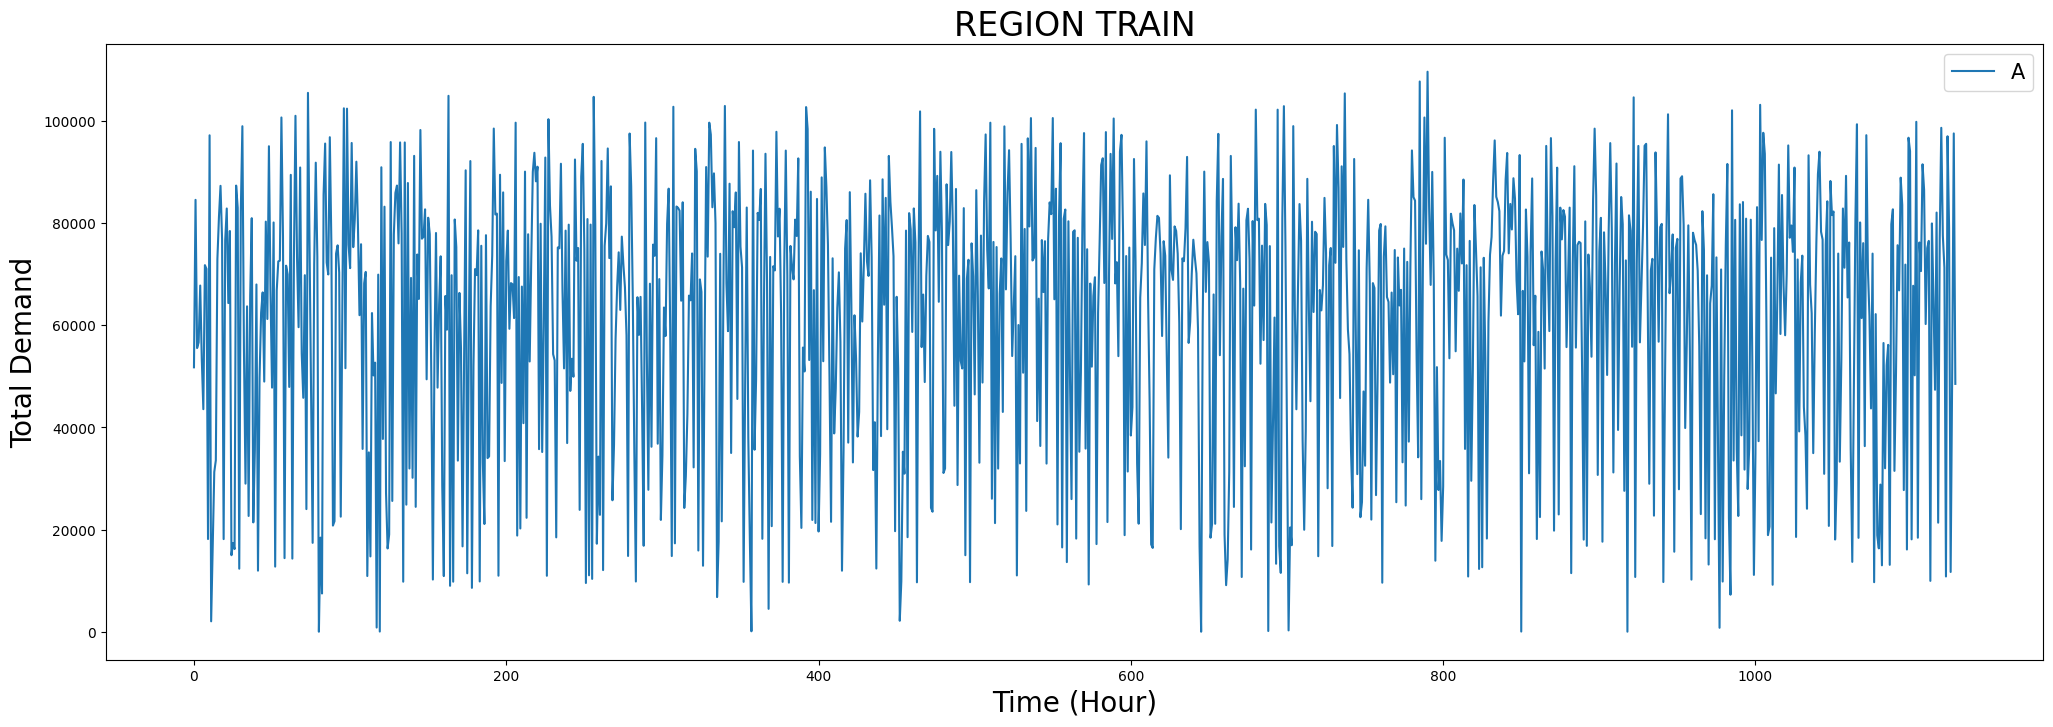

In [12]:
reshaped_reg_train = np.sum(trainx_1, axis=1).reshape(trainx_1.shape[0], local_image_size_x * local_image_size_y)
print("SPATIAL/REGION TRAIN SHAPE:", reshaped_reg_train.shape)

plt.figure(figsize=(25, 8))
plt.title('REGION TRAIN', fontsize=24)
plt.plot(np.sum(reshaped_reg_train, axis=1))
plt.legend('Actual', fontsize=15)
plt.ylabel('Total Demand', fontsize=20)
plt.xlabel('Time (Hour)', fontsize=20)
plt.show()

SPATIAL/REGION TRAIN SHAPE: (283, 900)


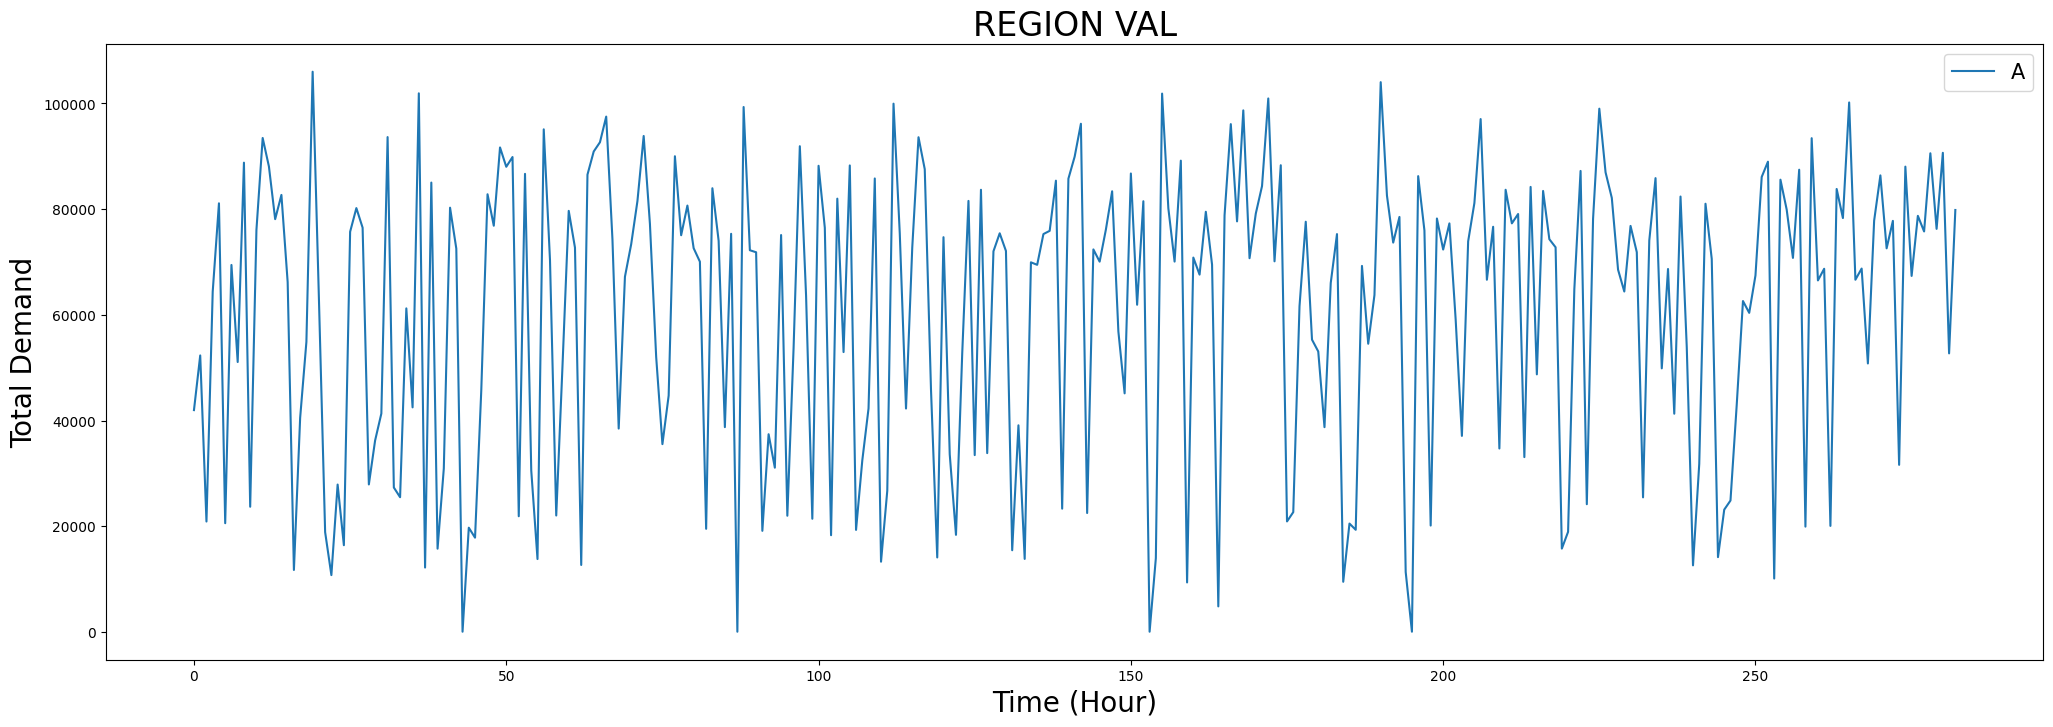

In [13]:
reshaped_reg_val = np.sum(valx_1, axis=1).reshape(valx_1.shape[0], local_image_size_x * local_image_size_y)
print("SPATIAL/REGION TRAIN SHAPE:", reshaped_reg_val.shape)

plt.figure(figsize=(25, 8))
plt.title('REGION VAL', fontsize=24)
plt.plot(np.sum(reshaped_reg_val, axis=1))
plt.legend('Actual', fontsize=15)
plt.ylabel('Total Demand', fontsize=20)
plt.xlabel('Time (Hour)', fontsize=20)
plt.show()

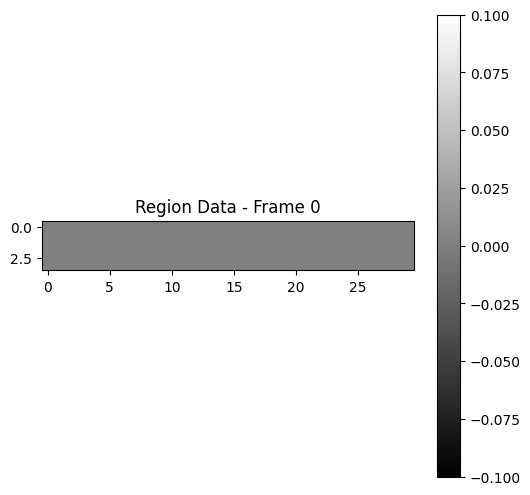

In [14]:
frame_index = 0
# Plot a single frame
plt.figure(figsize=(6, 6))
plt.imshow(trainx_1[frame_index, :, :, 0], cmap='gray')
plt.colorbar()
plt.title(f"Region Data - Frame {frame_index}")
plt.show()